In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
#from xgboost import predict_proba
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error  
import xgboost as xgb
from sklearn.model_selection import GridSearchCV #网格搜索
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn.model_selection import train_test_split                 
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import torch.utils.data as Data
from sklearn import preprocessing

In [2]:
m = loadmat("OCD_90_200_fMRI.mat") 

m.keys()
print(m.keys())
print(m['NC'].shape)
print(m['OCD'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'NC', 'OCD'])
(20, 90, 200)
(62, 90, 200)


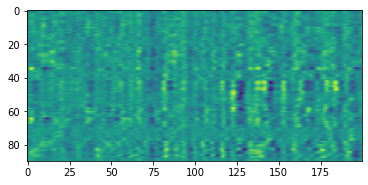

In [12]:
plt.imshow(m['NC'][1])

In [3]:
#用相关矩阵
OCD=np.zeros((m['OCD'].shape[0],90,90))
for i in range(m['OCD'].shape[0]):
    OCD[i]=np.cov(m['OCD'][i][:,15:])
    
NC=np.zeros((m['NC'].shape[0],90,90))
for i in range(m['NC'].shape[0]):
    NC[i]=np.cov(m['NC'][i][:,15:])

In [4]:
std = preprocessing.StandardScaler()

for i in range(OCD.shape[0]):
    OCD[i] = std.fit_transform(OCD[i])
for i in range(NC.shape[0]):
    NC[i] = std.fit_transform(NC[i])

cov_OCD=np.zeros((m['OCD'].shape[0],4005))
#cov_AD=np.zeros((m['AD'].shape[0],90,90))
for i in range(m['OCD'].shape[0]):
    cov_OCD_i=np.triu(OCD[i], k=1)
    cov_OCD[i]=cov_OCD_i[np.nonzero(cov_OCD_i)].reshape(1,-1)
    cov_OCD[i][np.where(cov_OCD[i]<cov_OCD[i].mean() )]=0
    #cov_FTD[i][np.where(cov_FTD[i]>cov_FTD[i].mean()*2 )]=cov_FTD[i].max()
    #cov_AD[i][np.where(cov_AD[i]>np.median(cov_AD[i]) )]=2
    #cov_AD[i][np.where(cov_AD[i]>np.median(cov_AD[i])*3/2 )]=1
cov_NC=np.zeros((m['NC'].shape[0],4005))
#cov_AD=np.zeros((m['AD'].shape[0],90,90))
for i in range(m['NC'].shape[0]):
    cov_NC_i=np.triu(NC[i], k=1)
    cov_NC[i]=cov_NC_i[np.nonzero(cov_NC_i)].reshape(1,-1)
    cov_NC[i][np.where(cov_NC[i]<cov_NC[i].mean() )]=0
    #cov_NC[i][np.where(cov_NC[i]>cov_NC[i].mean()*2 )]=cov_NC[i].max()
    #cov_NC[i][np.where(cov_NC[i]>np.median(cov_NC[i]) )]=2
    #cov_NC[i][np.where(cov_NC[i]>np.median(cov_NC[i])*3/2 )]=1

In [5]:
#展平
#std = preprocessing.StandardScaler()
#for i in range(cov_AD.shape[0]):
#    cov_AD[i] = std.fit_transform(cov_AD[i],axis=0)
#for i in range(cov_NC.shape[0]):
#    cov_NC[i] = std.fit_transform(cov_NC[i],axis=0)

    
OCD = cov_OCD.reshape(62,-1)
NC = cov_NC.reshape(20,-1)

OCD = pd.DataFrame(OCD)
NC = pd.DataFrame(NC)

OCD['label'] = [0]*62
NC['label'] = [1]*20

df = OCD.append(NC)
label = df['label']
df=df.drop(['label'],axis = 1)

OCD=OCD.drop(['label'],axis = 1)
NC=NC.drop(['label'],axis = 1)

In [121]:
x_train,x_test,y_train,y_test = train_test_split(df , label, test_size = 0.1 )  

In [122]:
df

,0,1,2,3,4,5,6,7,8,9,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,1.554889,1.290984,1.344766,1.103306,1.239039,1.221746,1.329479,0.766866,0.498638,1.161565,...,0.725752,0.844331,0.788274,0.794635,1.210805,1.067428,0.776450,1.393061,1.309286,0.000000
1,0.737521,0.000000,0.118192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.875599,1.135583,1.525888,2.375545,2.237309,1.793221,1.380202,1.139793,1.000900,0.209006
2,0.259213,0.000000,0.000000,0.000000,0.000000,0.274070,0.280659,0.209714,0.000000,0.863742,...,0.082918,0.688213,0.388056,0.930867,1.876107,1.273123,2.003858,1.272948,2.352372,0.000000
3,1.212171,0.213868,0.382639,0.000000,0.000000,0.081880,0.262797,0.000000,0.000000,0.783420,...,1.617577,2.156406,1.671368,1.045601,1.940848,1.482498,0.627927,0.761765,0.000000,0.000000
4,1.510814,0.467739,0.137999,0.336467,0.069635,0.000000,0.000000,0.105547,0.034609,1.117674,...,0.996935,1.306035,0.564643,0.802340,0.883356,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.471198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.516546,...,0.316480,0.768139,0.614286,0.788739,1.730226,1.356475,0.948755,0.149694,0.789306,0.140644
16,1.229501,0.733259,0.430989,0.678639,0.000000,0.477521,0.312448,0.625189,0.000000,1.467018,...,0.415646,1.098503,0.372527,1.561168,2.587649,2.032045,1.264066,1.147791,1.625063,0.000000
17,0.377549,0.253835,0.272795,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.477994,...,0.122017,1.232278,0.279938,1.425650,1.846115,0.758933,0.732451,0.236404,0.573199,0.056680
18,1.097099,0.100571,0.074691,0.203955,0.000000,0.360131,0.011640,-0.003099,0.000000,1.028410,...,1.287053,1.442081,1.135465,1.575590,0.675477,0.272007,0.329921,0.841293,0.895050,0.217654


In [123]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

print(torch.__version__)

1.9.0


In [124]:
train_dataset = Data.TensorDataset(torch.tensor(x_train.values), torch.tensor(y_train.values))
test_dataset = Data.TensorDataset(torch.tensor(x_test.values), torch.tensor(y_test.values))
batch_size = 256
num_workers = 0
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [125]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device 
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                pred = net(X.to(device).to(torch.float32)).argmax(dim=1)
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device).to(torch.float32)).argmax(dim=1) == y.to(device).to(torch.float32)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n , pred

In [126]:
def all_results(pred,y):
    from sklearn.metrics import accuracy_score,roc_auc_score,auc,confusion_matrix,roc_curve
    fpr,tpr,threshold = roc_curve(y, pred) 
    roc_auc= auc(fpr,tpr)

    if(len(set(y))!=1):
        roc=roc_auc_score(y, pred)
        sensitivity=confusion_matrix(y, pred)[0][0]/(confusion_matrix(y, pred)[0][0]+confusion_matrix(y, pred)[0][1])
        specificity=confusion_matrix(y, pred)[1][1]/(confusion_matrix(y, pred)[1][1]+confusion_matrix(y, pred)[1][0])
    else:
        roc=0
        sensitivity=0
        specificity=0
    return roc,sensitivity,specificity

In [127]:
import time
from sklearn.metrics import accuracy_score,roc_auc_score,auc,confusion_matrix,roc_curve

num_inputs = 4005
num_outputs = 2
hidden_dim1=256
hidden_dim2=32
hidden_dim3=16
#定义模型（添加）
class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet,self).__init__()
        #self.flatten = d2l.FlattenLayer()
        self.linear1 = nn.Linear(num_inputs,hidden_dim1)
        self.relu=nn.ReLU()
        self.batchNorm1d1 = nn.BatchNorm1d(hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, num_outputs)
        self.batchNorm1d2 = nn.BatchNorm1d(hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, num_outputs)
        #self.batchNorm1d3 = nn.BatchNorm1d(hidden_dim3)
        #self.linear4 = nn.Linear(hidden_dim3, num_outputs)
        self.dropout = nn.Dropout(p=0.1)  # dropout训练
        #self.linear3 = nn.Linear(hidden_dim, num_outputs)
    def init_weights(self):
        self.linear.weight.data.uniform_(-1, 1)
        self.linear.bias.data.fill_(0)
    def forward(self, x): # x shape: (batch, 1, 28, 28)
        y = self.linear1(x.view(x.shape[0],-1))
        #y = self.batchNorm1d1(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.linear2(y)
        #y = self.batchNorm1d2(y)
        #y = self.relu(y)
        #y = self.dropout(y)
       # y = self.linear3(y)
        #y = self.relu(y)
        #y = self.batchNorm1d3(y)
        #y = self.dropout(y)
        #y = self.linear4(y)
        return y
net = LinearNet(num_inputs,num_outputs)
#for params in net.parameters(): 
#    init.normal_(params, mean=0, std=0.01)   #参数初始化
print(net) 

for X, y in test_iter:
    y_true = y
#roc,sensitivity,specificity = []

    
num_epochs = 100
now_time = time.time()
losses = []
accuracies = []

plot_test = []
plot_train = []
plot_roc = []
plot_sensitivity = []
plot_specificity = []
#损失函数和优化器
loss = torch.nn.CrossEntropyLoss()
LR = 0.1
optimizer = torch.optim.SGD(
                            net.parameters(), 
                            lr = LR,
                            weight_decay = 0.1
                             )

for epoch in range(num_epochs):
    
    if epoch % 10 == 0:
        for p in optimizer.param_groups:
            p['lr'] *= 0.95
    
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    running_loss = 0.0
    
    for X, y in train_iter:
        y_hat = net(X.to(torch.float32))
        l = loss(y_hat,y).sum()#数据集损失函数的值=每个样本的损失函数值的和。            
        optimizer.zero_grad()#对优化函数梯度清零
        l.backward()#对损失函数求梯度
        optimizer.step() 
        
        running_loss += l.item()
        n += y.shape[0]
    #print(train_acc_sum/n)
    train_acc , train_pred=evaluate_accuracy(train_iter, net)
    test_acc , test_pred= evaluate_accuracy(test_iter, net)
    plot_test.append(test_acc)
    
    a,b,c = all_results(test_pred,y_true)
    plot_roc .append(a)
    plot_sensitivity .append(b)
    plot_specificity .append(c)
    
    plot_train.append(train_acc)
    accuracies.append(test_acc)
    losses.append(running_loss)
    print(a,b,c)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
          % (epoch + 1, running_loss, train_acc , test_acc))
    pre_time = now_time
    now_time = time.time()
    print('该轮训练用时：',now_time-pre_time)

LinearNet(
  (linear1): Linear(in_features=4005, out_features=256, bias=True)
  (relu): ReLU()
  (batchNorm1d1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=256, out_features=2, bias=True)
  (batchNorm1d2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
0.5 1.0 0.0
epoch 1, loss 0.6246, train acc 0.740, test acc 0.889
该轮训练用时： 0.020956993103027344
0.5 0.0 1.0
epoch 2, loss 0.8686, train acc 0.260, test acc 0.111
该轮训练用时： 0.025919437408447266
0.5 1.0 0.0
epoch 3, loss 0.8859, train acc 0.740, test acc 0.889
该轮训练用时： 0.01595473289489746
0.5 1.0 0.0
epoch 4, loss 0.6383, train acc 0.740, test acc 0.889
该轮训练用时： 0.016954660415649414
0.5 1.0 0.0
epoch 5, loss 0.5617, train acc 0.740, test acc 0.889
该轮训练用时： 0.018949508666992188
0.5 1.0 0.0
epoch 6, loss 0.5088, train acc 0.740, test acc 0.

0.5 1.0 0.0
epoch 84, loss 0.0425, train acc 1.000, test acc 0.889
该轮训练用时： 0.018950939178466797
0.4375 0.875 0.0
epoch 85, loss 0.0374, train acc 1.000, test acc 0.889
该轮训练用时： 0.019945144653320312
0.5 1.0 0.0
epoch 86, loss 0.0445, train acc 1.000, test acc 0.889
该轮训练用时： 0.01795172691345215
0.5 1.0 0.0
epoch 87, loss 0.0371, train acc 1.000, test acc 0.778
该轮训练用时： 0.01795220375061035
0.5 1.0 0.0
epoch 88, loss 0.0515, train acc 1.000, test acc 0.889
该轮训练用时： 0.018949031829833984
0.4375 0.875 0.0
epoch 89, loss 0.0391, train acc 1.000, test acc 0.889
该轮训练用时： 0.016954898834228516
0.5 1.0 0.0
epoch 90, loss 0.0332, train acc 1.000, test acc 0.889
该轮训练用时： 0.016954898834228516
0.4375 0.875 0.0
epoch 91, loss 0.0338, train acc 1.000, test acc 0.889
该轮训练用时： 0.01795172691345215
0.4375 0.875 0.0
epoch 92, loss 0.0335, train acc 1.000, test acc 0.778
该轮训练用时： 0.01695418357849121
0.5 1.0 0.0
epoch 93, loss 0.0413, train acc 1.000, test acc 0.889
该轮训练用时： 0.01697564125061035
0.5 1.0 0.0
epoch 94, los

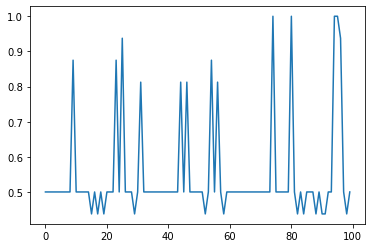

In [128]:
plt.plot(plot_roc)

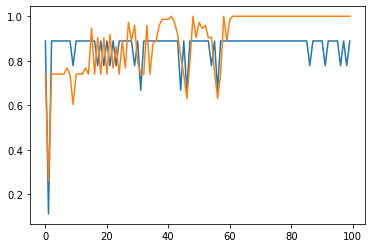

In [129]:
plt.plot(plot_test)
plt.plot(plot_train)

In [69]:
np.array(plot_test).max()

0.7777777777777778

In [142]:
# 使用交叉验证
from sklearn.model_selection import KFold

#x_train,x_test,y_train,y_test = train_test_split(df, label, test_size = 0.1)  


train = df
label == label

accuracy = []    
mean_1 = []
mean_2 = []
mean_3 = []
train_accuracy = []
k = 10
for i in range(k):
    kfold = KFold(n_splits=10,shuffle = True)
    print('第 %d 次交叉验证' %(i+1))
    test_acc_eve = []
    cnt = 1
    for train_index, test_index in kfold.split(train, label):

        #print(test_index)
        # train_index 就是分类的训练集的下标，test_index 就是分配的验证集的下标
        this_train_x, this_train_y = train.iloc[train_index], label.iloc[train_index]  # 本组训练集
        this_test_x, this_test_y = train.iloc[test_index], label.iloc[test_index]  # 本组验证集
        # 训练本组的数据，并计算准确率
        #model.fit(this_train_x, this_train_y)
        
        train_dataset = Data.TensorDataset(torch.tensor(this_train_x.values), torch.tensor(this_train_y.values))
        test_dataset = Data.TensorDataset(torch.tensor(this_test_x.values), torch.tensor(this_test_y.values))
        batch_size = 256
        num_workers = 0
        train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        for X, y in test_iter:
            y_true = y
        net = LinearNet(num_inputs,num_outputs)
        
        num_epochs = 100
        now_time = time.time()
        losses = []
        plot_roc = []
        plot_sensitivity = []
        plot_specificity = []
        test_accuracies = []
        train_accuracies = []
        #损失函数和优化器
        loss = torch.nn.CrossEntropyLoss()
        LR = 0.1
        optimizer = torch.optim.SGD(
                                    net.parameters(), 
                                    lr = LR,
                                    weight_decay = 0.1
                                     )
        best_pred = []
        best_y = []
        best_test_acc = 0
        for epoch in range(num_epochs):

            if epoch % 10 == 0:
                for p in optimizer.param_groups:
                    p['lr'] *= 0.95

            train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
            running_loss = 0.0

            for X, y in train_iter:
                y_hat = net(X.to(torch.float32))
                l = loss(y_hat,y).sum()#数据集损失函数的值=每个样本的损失函数值的和。            
                optimizer.zero_grad()#对优化函数梯度清零
                l.backward()#对损失函数求梯度
                optimizer.step() 

                running_loss += l.item()
                n += y.shape[0]
            #print(train_acc_sum/n)
            train_acc , train_pred=evaluate_accuracy(train_iter, net)
            test_acc , test_pred= evaluate_accuracy(test_iter, net)
            if test_acc>best_test_acc:
                best_test_acc = test_acc
            a,b,c = all_results(test_pred,y_true)
            plot_roc .append(a)
            plot_sensitivity .append(b)
            plot_specificity .append(c)    
                
            test_accuracies.append(test_acc)
            train_accuracies.append(train_acc)
            losses.append(running_loss)
            pre_time = now_time
            now_time = time.time()
        print('第 %d 折,train acc %.3f, test acc %.3f,test roc %.3f,test sensitivity %.3f,test specificity %.3f'
          % (cnt,np.array(train_accuracies).max() ,np.array(test_accuracies).max(),np.array(plot_roc)[-10:].max(),np.array( plot_sensitivity)[-10:].max(),np.array(plot_specificity)[-10:].max()))
        cnt = cnt+1
        test_acc_eve.append(np.array(test_accuracies).max())
        accuracy.append(np.array(test_accuracies).max())
        train_accuracy.append(np.array(train_accuracies).max())
        mean_1.append(np.array(plot_roc)[-10:].max())
        mean_2.append(np.array(plot_sensitivity)[-10:].max())
        mean_3.append(np.array(plot_specificity)[-10:].max())
    print(np.array(test_acc_eve).mean())
print('平均测试集准确率',np.array(accuracy).sum()/(k*10))
print('平均训练集准确率',np.array(train_accuracy).sum()/(k*10))
print('roc',np.array(mean_1).mean())
print('sensitivity',np.array(mean_2).mean())
print('specificity',np.array(mean_3).mean())

第 1 次交叉验证
第 1 折,train acc 1.000, test acc 1.000,test roc 0.000,test sensitivity 0.000,test specificity 0.000
第 2 折,train acc 1.000, test acc 0.778,test roc 0.750,test sensitivity 0.833,test specificity 0.667
第 3 折,train acc 1.000, test acc 0.875,test roc 0.750,test sensitivity 1.000,test specificity 0.500
第 4 折,train acc 1.000, test acc 0.875,test roc 1.000,test sensitivity 1.000,test specificity 1.000
第 5 折,train acc 1.000, test acc 1.000,test roc 1.000,test sensitivity 1.000,test specificity 1.000
第 6 折,train acc 1.000, test acc 0.875,test roc 0.429,test sensitivity 0.857,test specificity 0.000
第 7 折,train acc 1.000, test acc 0.875,test roc 0.500,test sensitivity 1.000,test specificity 0.000
第 8 折,train acc 1.000, test acc 0.875,test roc 0.667,test sensitivity 1.000,test specificity 0.333
第 9 折,train acc 1.000, test acc 1.000,test roc 1.000,test sensitivity 1.000,test specificity 1.000
第 10 折,train acc 1.000, test acc 0.875,test roc 0.929,test sensitivity 0.857,test specificity 1.000

C:\Users\12588\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


第 9 折,train acc 1.000, test acc 1.000,test roc 0.000,test sensitivity 0.000,test specificity 0.000
第 10 折,train acc 1.000, test acc 0.875,test roc 0.750,test sensitivity 1.000,test specificity 0.500
0.8652777777777778
第 3 次交叉验证
第 1 折,train acc 1.000, test acc 0.889,test roc 0.750,test sensitivity 1.000,test specificity 0.500
第 2 折,train acc 1.000, test acc 0.889,test roc 0.667,test sensitivity 1.000,test specificity 0.333
第 3 折,train acc 1.000, test acc 0.875,test roc 0.833,test sensitivity 1.000,test specificity 0.667
第 4 折,train acc 1.000, test acc 0.750,test roc 0.667,test sensitivity 1.000,test specificity 0.333
第 5 折,train acc 1.000, test acc 0.875,test roc 0.917,test sensitivity 0.833,test specificity 1.000
第 6 折,train acc 1.000, test acc 1.000,test roc 1.000,test sensitivity 1.000,test specificity 1.000
第 7 折,train acc 1.000, test acc 1.000,test roc 1.000,test sensitivity 1.000,test specificity 1.000
第 8 折,train acc 1.000, test acc 0.875,test roc 0.500,test sensitivity 1.000,tes

C:\Users\12588\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


第 4 折,train acc 1.000, test acc 1.000,test roc 0.000,test sensitivity 0.000,test specificity 0.000
第 5 折,train acc 1.000, test acc 1.000,test roc 0.833,test sensitivity 1.000,test specificity 0.667
第 6 折,train acc 1.000, test acc 1.000,test roc 1.000,test sensitivity 1.000,test specificity 1.000
第 7 折,train acc 1.000, test acc 0.625,test roc 0.700,test sensitivity 1.000,test specificity 0.400
第 8 折,train acc 1.000, test acc 1.000,test roc 0.875,test sensitivity 1.000,test specificity 0.750


C:\Users\12588\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


第 9 折,train acc 1.000, test acc 1.000,test roc 0.000,test sensitivity 0.000,test specificity 0.000
第 10 折,train acc 1.000, test acc 1.000,test roc 0.000,test sensitivity 0.000,test specificity 0.000
0.9166666666666666
第 5 次交叉验证
第 1 折,train acc 1.000, test acc 0.778,test roc 0.667,test sensitivity 1.000,test specificity 0.333
第 2 折,train acc 1.000, test acc 0.889,test roc 0.750,test sensitivity 1.000,test specificity 0.500
第 3 折,train acc 1.000, test acc 0.875,test roc 0.929,test sensitivity 0.857,test specificity 1.000
第 4 折,train acc 1.000, test acc 0.750,test roc 0.417,test sensitivity 0.833,test specificity 0.000
第 5 折,train acc 1.000, test acc 0.875,test roc 0.500,test sensitivity 1.000,test specificity 0.000
第 6 折,train acc 1.000, test acc 0.875,test roc 0.667,test sensitivity 0.833,test specificity 0.500
第 7 折,train acc 1.000, test acc 1.000,test roc 0.750,test sensitivity 1.000,test specificity 0.500


C:\Users\12588\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


第 8 折,train acc 1.000, test acc 1.000,test roc 0.000,test sensitivity 0.000,test specificity 0.000
第 9 折,train acc 1.000, test acc 0.750,test roc 0.750,test sensitivity 1.000,test specificity 0.500
第 10 折,train acc 1.000, test acc 1.000,test roc 1.000,test sensitivity 1.000,test specificity 1.000
0.8791666666666667
第 6 次交叉验证
第 1 折,train acc 1.000, test acc 1.000,test roc 0.875,test sensitivity 0.750,test specificity 1.000
第 2 折,train acc 1.000, test acc 0.778,test roc 0.679,test sensitivity 0.857,test specificity 0.500
第 3 折,train acc 1.000, test acc 0.875,test roc 0.750,test sensitivity 1.000,test specificity 0.500
第 4 折,train acc 1.000, test acc 0.875,test roc 0.833,test sensitivity 1.000,test specificity 0.667
第 5 折,train acc 1.000, test acc 0.750,test roc 0.500,test sensitivity 1.000,test specificity 0.000


C:\Users\12588\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


第 6 折,train acc 1.000, test acc 1.000,test roc 0.000,test sensitivity 0.000,test specificity 0.000
第 7 折,train acc 1.000, test acc 1.000,test roc 0.875,test sensitivity 1.000,test specificity 0.750
第 8 折,train acc 1.000, test acc 0.875,test roc 0.750,test sensitivity 1.000,test specificity 0.500
第 9 折,train acc 1.000, test acc 0.875,test roc 0.500,test sensitivity 1.000,test specificity 0.000
第 10 折,train acc 1.000, test acc 0.875,test roc 0.667,test sensitivity 1.000,test specificity 0.333
0.8902777777777778
第 7 次交叉验证
第 1 折,train acc 1.000, test acc 0.778,test roc 0.625,test sensitivity 1.000,test specificity 0.250


C:\Users\12588\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


第 2 折,train acc 1.000, test acc 1.000,test roc 0.000,test sensitivity 0.000,test specificity 0.000
第 3 折,train acc 1.000, test acc 1.000,test roc 1.000,test sensitivity 1.000,test specificity 1.000
第 4 折,train acc 1.000, test acc 0.875,test roc 0.667,test sensitivity 1.000,test specificity 0.500
第 5 折,train acc 1.000, test acc 0.750,test roc 0.667,test sensitivity 1.000,test specificity 0.333
第 6 折,train acc 1.000, test acc 0.875,test roc 0.833,test sensitivity 1.000,test specificity 0.667


C:\Users\12588\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


第 7 折,train acc 1.000, test acc 1.000,test roc 0.000,test sensitivity 0.000,test specificity 0.000
第 8 折,train acc 1.000, test acc 0.875,test roc 0.733,test sensitivity 0.667,test specificity 0.800
第 9 折,train acc 1.000, test acc 1.000,test roc 0.929,test sensitivity 0.857,test specificity 1.000
第 10 折,train acc 1.000, test acc 0.875,test roc 0.500,test sensitivity 1.000,test specificity 0.000
0.9027777777777779
第 8 次交叉验证
第 1 折,train acc 1.000, test acc 0.778,test roc 0.500,test sensitivity 1.000,test specificity 0.000
第 2 折,train acc 1.000, test acc 0.889,test roc 0.750,test sensitivity 1.000,test specificity 0.500
第 3 折,train acc 1.000, test acc 0.875,test roc 0.929,test sensitivity 0.857,test specificity 1.000
第 4 折,train acc 1.000, test acc 0.750,test roc 0.667,test sensitivity 0.833,test specificity 0.500
第 5 折,train acc 1.000, test acc 1.000,test roc 1.000,test sensitivity 1.000,test specificity 1.000


C:\Users\12588\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


第 6 折,train acc 1.000, test acc 1.000,test roc 0.000,test sensitivity 0.000,test specificity 0.000
第 7 折,train acc 1.000, test acc 0.875,test roc 0.833,test sensitivity 1.000,test specificity 0.667
第 8 折,train acc 1.000, test acc 0.750,test roc 0.500,test sensitivity 1.000,test specificity 0.000
第 9 折,train acc 1.000, test acc 0.750,test roc 0.500,test sensitivity 1.000,test specificity 0.000
第 10 折,train acc 1.000, test acc 0.875,test roc 0.875,test sensitivity 1.000,test specificity 1.000
0.8541666666666666
第 9 次交叉验证
第 1 折,train acc 1.000, test acc 0.889,test roc 0.833,test sensitivity 1.000,test specificity 0.667
第 2 折,train acc 1.000, test acc 1.000,test roc 1.000,test sensitivity 1.000,test specificity 1.000
第 3 折,train acc 1.000, test acc 1.000,test roc 0.929,test sensitivity 0.857,test specificity 1.000
第 4 折,train acc 1.000, test acc 1.000,test roc 1.000,test sensitivity 1.000,test specificity 1.000
第 5 折,train acc 1.000, test acc 0.875,test roc 1.000,test sensitivity 1.000,tes

C:\Users\12588\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


第 9 折,train acc 1.000, test acc 1.000,test roc 0.000,test sensitivity 0.000,test specificity 0.000
第 10 折,train acc 1.000, test acc 0.875,test roc 0.833,test sensitivity 1.000,test specificity 0.667
0.913888888888889
第 10 次交叉验证
第 1 折,train acc 1.000, test acc 0.889,test roc 0.438,test sensitivity 0.875,test specificity 0.000
第 2 折,train acc 1.000, test acc 0.889,test roc 0.833,test sensitivity 1.000,test specificity 0.667
第 3 折,train acc 1.000, test acc 1.000,test roc 1.000,test sensitivity 1.000,test specificity 1.000
第 4 折,train acc 1.000, test acc 1.000,test roc 1.000,test sensitivity 1.000,test specificity 1.000
第 5 折,train acc 1.000, test acc 1.000,test roc 1.000,test sensitivity 1.000,test specificity 1.000
第 6 折,train acc 1.000, test acc 0.875,test roc 0.500,test sensitivity 1.000,test specificity 0.000
第 7 折,train acc 1.000, test acc 0.875,test roc 0.500,test sensitivity 1.000,test specificity 0.000
第 8 折,train acc 1.000, test acc 0.750,test roc 0.567,test sensitivity 0.800,tes